## Import Toolkit

In [1]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warnings
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Prepare data and load into DataFrame

In [2]:
train_data_path = '/kaggle/input/indian-food-images-12-different-dishes/Indian Cuisine/train'

filepaths = []
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    
    f_path = os.path.join(train_data_path , fold)
    imgs = os.listdir(f_path)
    
    for img in imgs:
        img_path = os.path.join(f_path , img)
        
        filepaths.append(img_path)
        labels.append(fold)
        
fseries = pd.Series(filepaths , name = 'Filepaths')
lseries = pd.Series(labels , name = 'Labels')

train_df = pd.concat([fseries , lseries] , axis = 1)

In [3]:
train_df

Filepaths   Labels
0     /kaggle/input/indian-food-images-12-different-...    Momos
1     /kaggle/input/indian-food-images-12-different-...    Momos
2     /kaggle/input/indian-food-images-12-different-...    Momos
3     /kaggle/input/indian-food-images-12-different-...    Momos
4     /kaggle/input/indian-food-images-12-different-...    Momos
...                                                 ...      ...
3041  /kaggle/input/indian-food-images-12-different-...  Biryani
3042  /kaggle/input/indian-food-images-12-different-...  Biryani
3043  /kaggle/input/indian-food-images-12-different-...  Biryani
3044  /kaggle/input/indian-food-images-12-different-...  Biryani
3045  /kaggle/input/indian-food-images-12-different-...  Biryani

[3046 rows x 2 columns]

In [4]:
test_data_path = '/kaggle/input/indian-food-images-12-different-dishes/Indian Cuisine/test'

filepaths = []
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    
    f_path = os.path.join(test_data_path , fold)
    imgs = os.listdir(f_path)
    
    for img in imgs:
        img_path = os.path.join(f_path , img)
        
        filepaths.append(img_path)
        labels.append(fold)
        
fseries = pd.Series(filepaths , name = 'Filepaths')
lseries = pd.Series(labels , name = 'Labels')

test_df = pd.concat([fseries , lseries] , axis = 1)

In [5]:
test_df

Filepaths   Labels
0    /kaggle/input/indian-food-images-12-different-...    Momos
1    /kaggle/input/indian-food-images-12-different-...    Momos
2    /kaggle/input/indian-food-images-12-different-...    Momos
3    /kaggle/input/indian-food-images-12-different-...    Momos
4    /kaggle/input/indian-food-images-12-different-...    Momos
..                                                 ...      ...
494  /kaggle/input/indian-food-images-12-different-...  Biryani
495  /kaggle/input/indian-food-images-12-different-...  Biryani
496  /kaggle/input/indian-food-images-12-different-...  Biryani
497  /kaggle/input/indian-food-images-12-different-...  Biryani
498  /kaggle/input/indian-food-images-12-different-...  Biryani

[499 rows x 2 columns]

In [6]:
val_data_path = '/kaggle/input/indian-food-images-12-different-dishes/Indian Cuisine/val'

filepaths = []
labels = []

folds = os.listdir(val_data_path)

for fold in folds:
    
    f_path = os.path.join(val_data_path , fold)
    imgs = os.listdir(f_path)
    
    for img in imgs:
        img_path = os.path.join(f_path , img)
        
        filepaths.append(img_path)
        labels.append(fold)
        
fseries = pd.Series(filepaths , name = 'Filepaths')
lseries = pd.Series(labels , name = 'Labels')

val_df = pd.concat([fseries , lseries] , axis = 1)

In [7]:
val_df

Filepaths   Labels
0    /kaggle/input/indian-food-images-12-different-...    Momos
1    /kaggle/input/indian-food-images-12-different-...    Momos
2    /kaggle/input/indian-food-images-12-different-...    Momos
3    /kaggle/input/indian-food-images-12-different-...    Momos
4    /kaggle/input/indian-food-images-12-different-...    Momos
..                                                 ...      ...
829  /kaggle/input/indian-food-images-12-different-...  Biryani
830  /kaggle/input/indian-food-images-12-different-...  Biryani
831  /kaggle/input/indian-food-images-12-different-...  Biryani
832  /kaggle/input/indian-food-images-12-different-...  Biryani
833  /kaggle/input/indian-food-images-12-different-...  Biryani

[834 rows x 2 columns]

## Image Data Generator


In [8]:
img_size = (224 , 224)
batches = 32
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'Filepaths' , y_col = 'Labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size = batches)
test_gen = ts_gen.flow_from_dataframe(test_df , x_col = 'Filepaths' , y_col = 'Labels',target_size = img_size ,
                                     class_mode = 'categorical' , color_mode = 'rgb' , shuffle = False , batch_size = batches)
valid_gen = ts_gen.flow_from_dataframe(val_df , x_col = 'Filepaths' , y_col = 'Labels' , target_size= img_size,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True, batch_size = batches)

Found 3046 validated image filenames belonging to 12 classes.
Found 499 validated image filenames belonging to 12 classes.
Found 834 validated image filenames belonging to 12 classes.


In [9]:
# Calculate class counts
class_counts = train_df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Calculate the total number of images in train_df
total_images = len(train_df)

# Calculate the percentage for each class based on the total number of images
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# Create the bar chart using Plotly Express
fig = px.bar(class_counts, x='Class', y='Percentage',
             title='Class Balance (Percentage)',
             labels={'Class': 'Class Label', 'Percentage': 'Percentage (%)'},
             color='Class', 
             height=600)

# Customize the layout
fig.update_layout(xaxis_title='Class Label', yaxis_title='Percentage (%)')
fig.show()

## Show Sample From Train Data

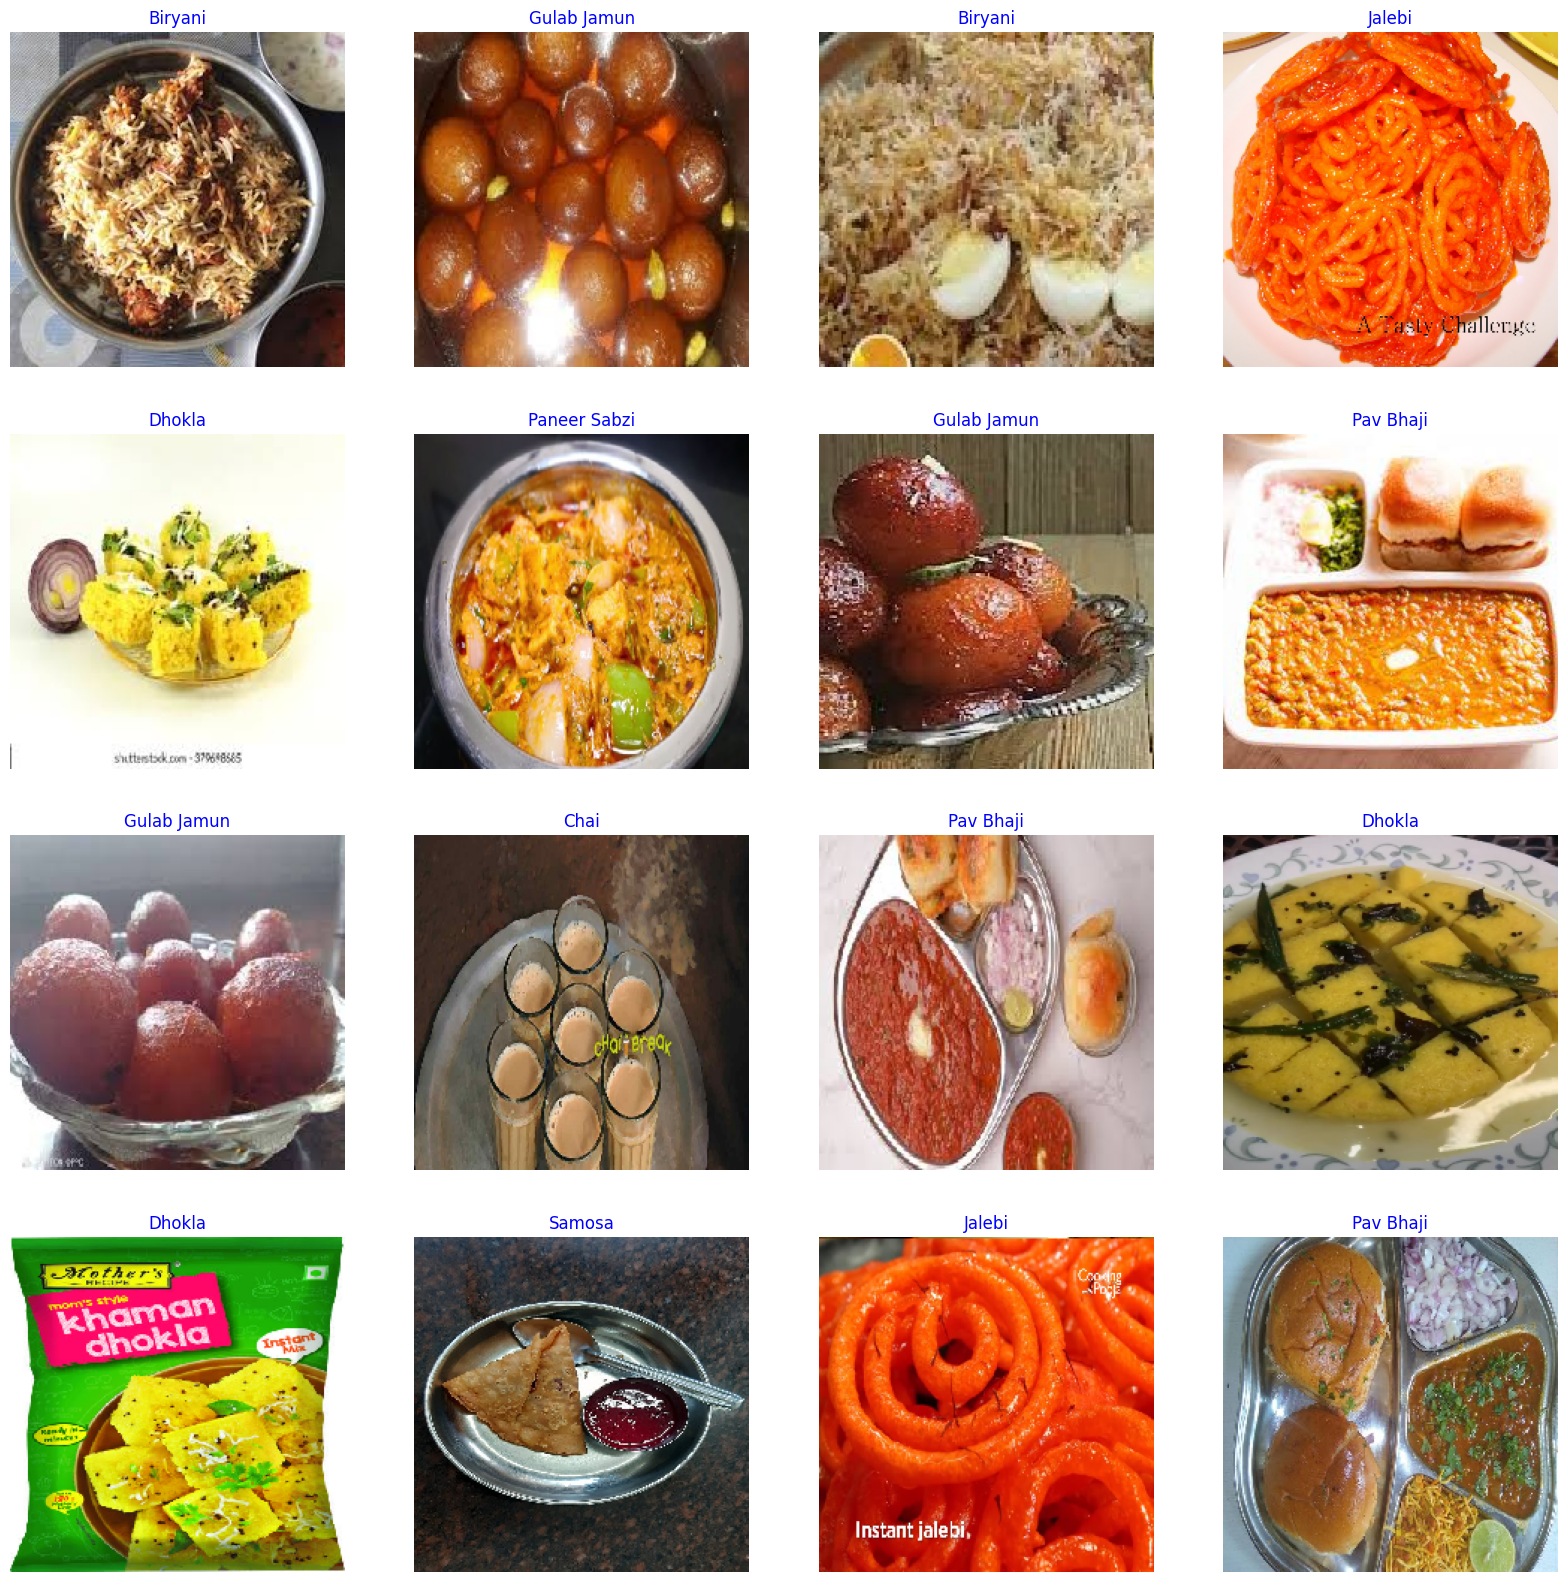

In [10]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images , labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize = (20, 20))

for i in range(min(16 , num_samples)):
    plt.subplot(4,4, i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize = 12)
    plt.axis('off')
plt.show();

## Model Structure

In [11]:
base_model = tf.keras.applications.xception.Xception(weights= 'imagenet' ,include_top = False , input_shape = img_shape ,
                                                     pooling = 'max' )
num_classes = len(classes)
model = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate = 0.4 , seed = 40),
    Dense(num_classes , activation= 'softmax' )
])
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 21,397,300
Trainable params: 21,338,676
Non-trainable params: 58,624
_______________________________________

In [12]:
history = model.fit(x= train_gen , validation_data= valid_gen , epochs= 20 , verbose = 1 , validation_steps = None , shuffle = False)

Epoch 1/20
96/96 [==============================] - 81s 514ms/step - loss: 7.9760 - accuracy: 0.7994 - val_loss: 6.9332 - val_accuracy: 0.8765
Epoch 2/20
96/96 [==============================] - 47s 486ms/step - loss: 5.6368 - accuracy: 0.9705 - val_loss: 5.4963 - val_accuracy: 0.9568
Epoch 3/20
96/96 [==============================] - 46s 483ms/step - loss: 4.3182 - accuracy: 0.9892 - val_loss: 4.0371 - val_accuracy: 0.9592
Epoch 4/20
96/96 [==============================] - 46s 475ms/step - loss: 3.3526 - accuracy: 0.9954 - val_loss: 3.1084 - val_accuracy: 0.9688
Epoch 5/20
96/96 [==============================] - 47s 491ms/step - loss: 2.5947 - accuracy: 0.9984 - val_loss: 2.3598 - val_accuracy: 0.9700
Epoch 6/20
96/96 [==============================] - 46s 473ms/step - loss: 2.0145 - accuracy: 0.9987 - val_loss: 1.8249 - val_accuracy: 0.9724
Epoch 7/20
96/96 [==============================] - 46s 482ms/step - loss: 1.5483 - accuracy: 0.9984 - val_loss: 1.4158 - val_accuracy: 0.9688

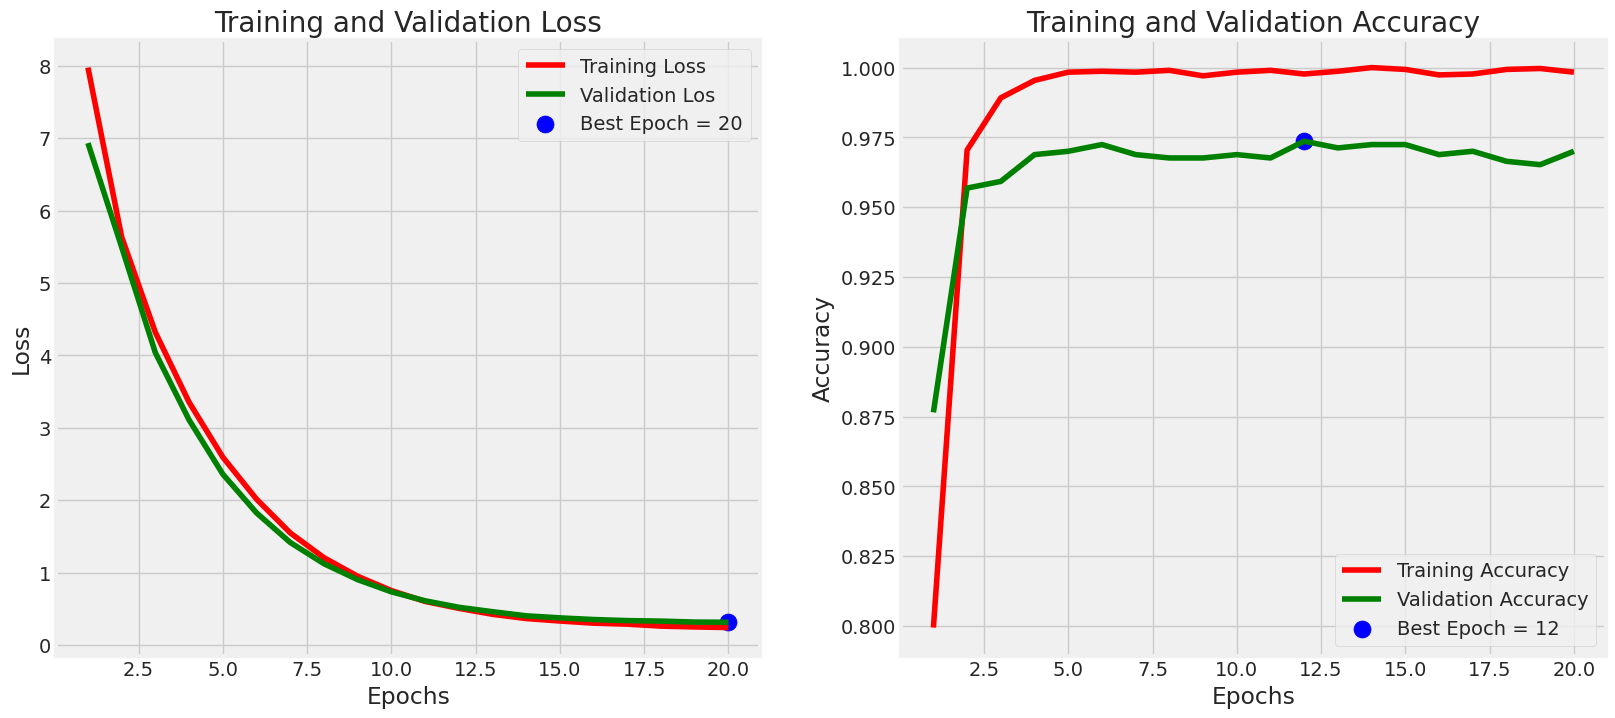

In [13]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs ,train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs ,val_loss , 'g' , label = 'Validation Los')
plt.scatter(index_loss + 1 ,val_lowest , s = 150 , c = 'blue' , label = loss_label )
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label= 'Validation Accuracy')
plt.scatter(index_acc +1 , val_highest , s= 150 , c = 'blue' , label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

## Model Evaluation

In [14]:
train_score = model.evaluate(train_gen ,steps= 8 , verbose = 1)
val_score = model.evaluate(valid_gen ,steps= 8 , verbose = 1)
test_score = model.evaluate(test_gen ,steps= 8 , verbose = 1)

8/8 [==============================] - 1s 162ms/step - loss: 0.4108 - accuracy: 0.9531


In [15]:
print(f'Train Loss = {round(train_score[0],5)} and Train accuracy = {train_score[1]}')
print(f'Validation Loss = {round(val_score[0],5)} and Validation accuracy = {val_score[1]}')
print(f'Test Loss = {round(test_score[0],5)} and Test accuracy = {test_score[1]}')

Train Loss = 0.20386 and Train accuracy = 1.0
Validation Loss = 0.2639 and Validation accuracy = 0.9921875
Test Loss = 0.41085 and Test accuracy = 0.953125


## Model Prediction

In [17]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds, axis = 1)

## Confusion Matrix and Classification Report

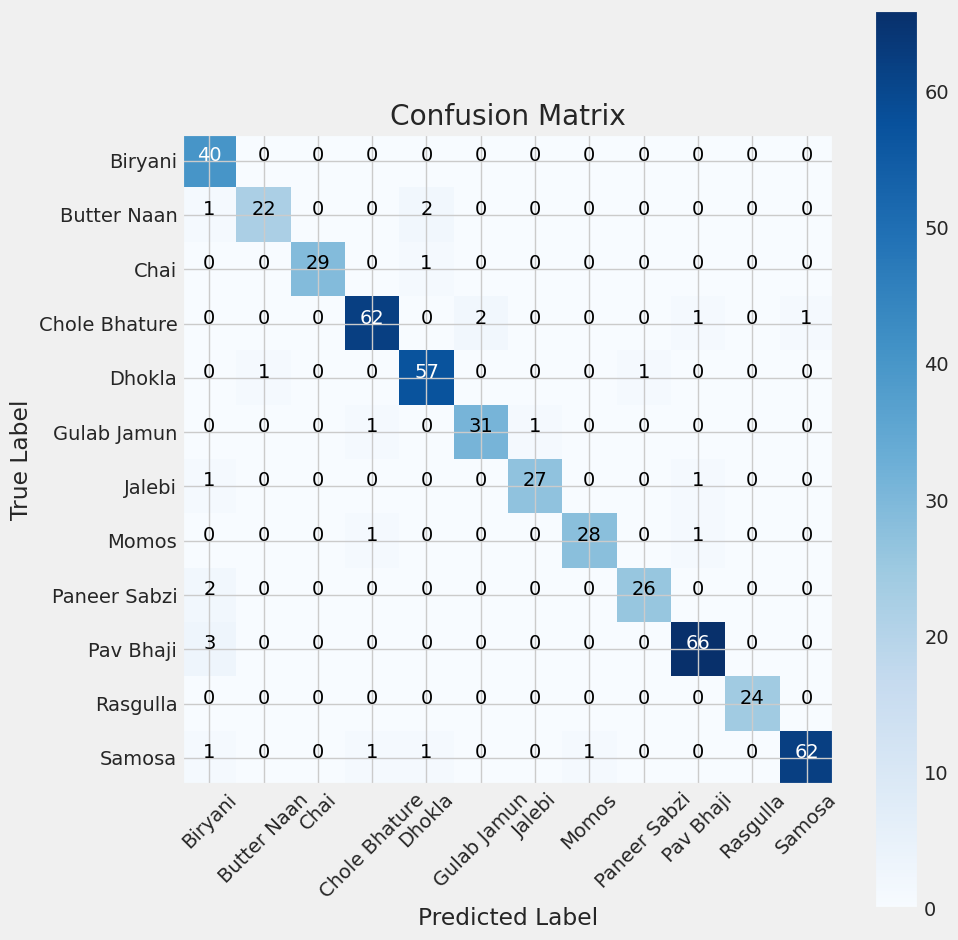

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [20]:
#Classification report
print(classification_report(test_gen.classes , y_pred , target_names = classes))

               precision    recall  f1-score   support

      Biryani       0.83      1.00      0.91        40
  Butter Naan       0.96      0.88      0.92        25
         Chai       1.00      0.97      0.98        30
Chole Bhature       0.95      0.94      0.95        66
       Dhokla       0.93      0.97      0.95        59
  Gulab Jamun       0.94      0.94      0.94        33
       Jalebi       0.96      0.93      0.95        29
        Momos       0.97      0.93      0.95        30
 Paneer Sabzi       0.96      0.93      0.95        28
    Pav Bhaji       0.96      0.96      0.96        69
     Rasgulla       1.00      1.00      1.00        24
       Samosa       0.98      0.94      0.96        66

     accuracy                           0.95       499
    macro avg       0.95      0.95      0.95       499
 weighted avg       0.95      0.95      0.95       499

